✅ Quantitative results saved to 'country_anomaly_full_data.xlsx'


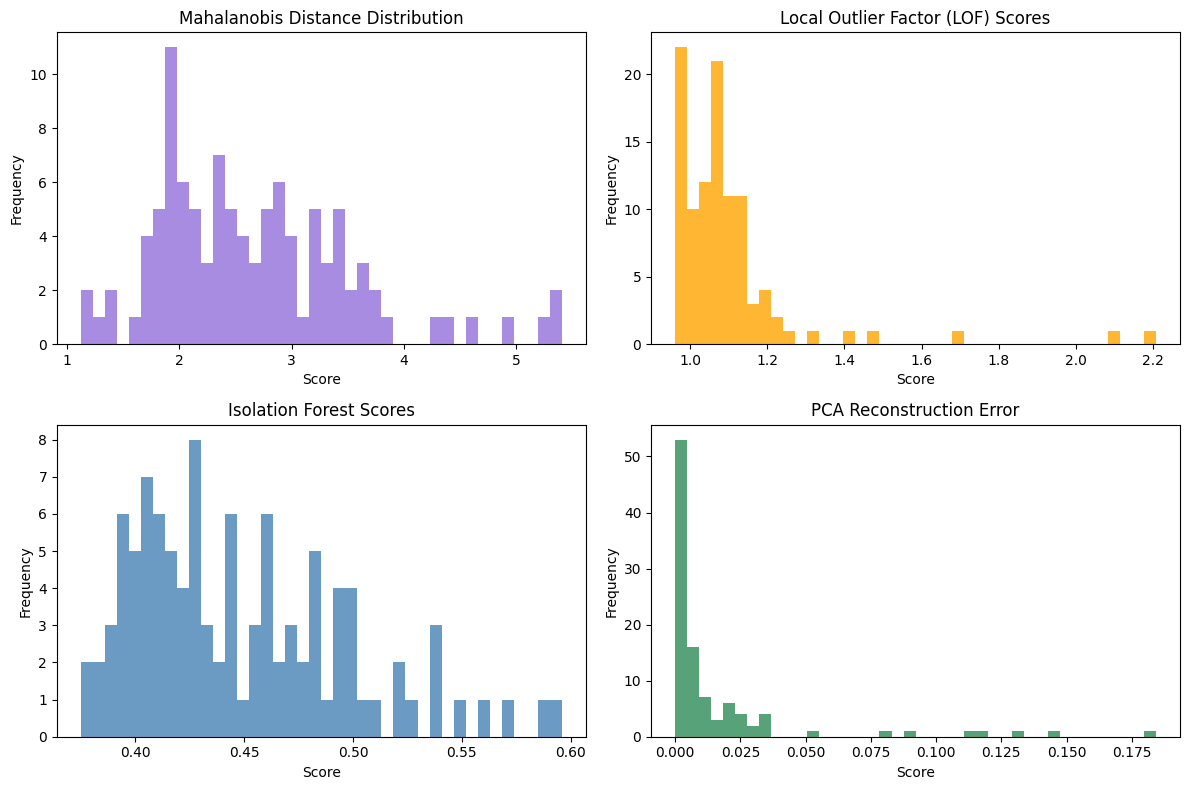

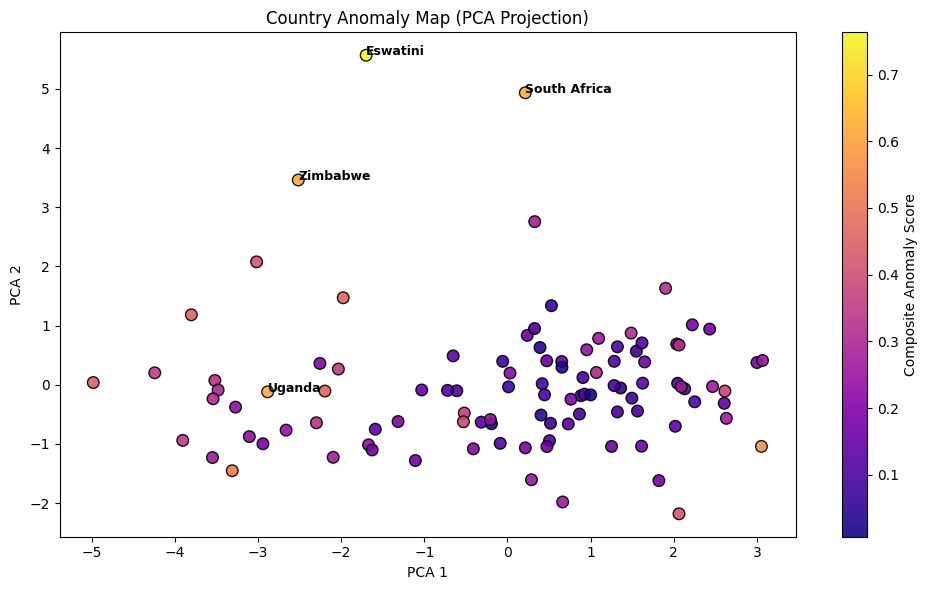


🔎 Top 4 Countries by Composite Anomaly Score:

     Country  Mahalanobis      LOF  IsolationForest  PCA_Error  Composite_Score
    Eswatini     1.000000 1.000000         1.000000   0.052922         0.763231
South Africa     0.884340 0.908580         0.727620   0.009025         0.632391
    Zimbabwe     0.992913 0.582646         0.884567   0.043512         0.625909
      Uganda     0.812393 0.148196         0.537446   1.000000         0.624508


In [3]:
# --- final_country_anomaly_full_visuals.py ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from scipy.stats import zscore
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt

# 1️⃣ Load dataset
file_path = "cleaned_dataset_final.xlsx"  # or .xls if needed
df = pd.read_excel(file_path)

if "Country" not in df.columns:
    raise ValueError("Dataset must include a 'Country' column!")

countries = df["Country"]
numeric_df = df.select_dtypes(include=[np.number]).dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# ------------------------------------------------------
# 2️⃣ Statistical-based: Mahalanobis Distance
# ------------------------------------------------------
cov_matrix = np.cov(X_scaled, rowvar=False)
inv_cov = np.linalg.pinv(cov_matrix)
mean_vec = np.mean(X_scaled, axis=0)
mahal_dist = np.array([mahalanobis(x, mean_vec, inv_cov) for x in X_scaled])
mahal_norm = (mahal_dist - mahal_dist.min()) / (mahal_dist.max() - mahal_dist.min())

# ------------------------------------------------------
# 3️⃣ Proximity-based: Local Outlier Factor (LOF)
# ------------------------------------------------------
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_pred = lof.fit_predict(X_scaled)
lof_scores = -lof.negative_outlier_factor_
lof_norm = (lof_scores - lof_scores.min()) / (lof_scores.max() - lof_scores.min())

# ------------------------------------------------------
# 4️⃣ Isolation-based: Isolation Forest
# ------------------------------------------------------
iforest = IsolationForest(contamination=0.05, random_state=42)
iso_pred = iforest.fit_predict(X_scaled)
iso_scores = -iforest.score_samples(X_scaled)
iso_norm = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())

# ------------------------------------------------------
# 5️⃣ Reconstruction-based: PCA Reconstruction Error
# ------------------------------------------------------
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)
recon_norm = (reconstruction_error - reconstruction_error.min()) / (
    reconstruction_error.max() - reconstruction_error.min()
)

# ------------------------------------------------------
# 6️⃣ Combine quantitative results
# ------------------------------------------------------
results = pd.DataFrame({
    "Country": countries,
    "Mahalanobis": mahal_norm,
    "LOF": lof_norm,
    "IsolationForest": iso_norm,
    "PCA_Error": recon_norm
})
results["Composite_Score"] = results[["Mahalanobis", "LOF", "IsolationForest", "PCA_Error"]].mean(axis=1)
results["Rank"] = results["Composite_Score"].rank(ascending=False)

# ------------------------------------------------------
# 7️⃣ Save data
# ------------------------------------------------------
results_sorted = results.sort_values("Composite_Score", ascending=False)
results_sorted.to_excel("country_anomaly_full_data.xlsx", index=False)
print("✅ Quantitative results saved to 'country_anomaly_full_data.xlsx'")

# ------------------------------------------------------
# 8️⃣ Generate all 4 anomaly distribution plots
# ------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

axes[0].hist(mahal_dist, bins=40, color='mediumpurple', alpha=0.8)
axes[0].set_title("Mahalanobis Distance Distribution")

axes[1].hist(lof_scores, bins=40, color='orange', alpha=0.8)
axes[1].set_title("Local Outlier Factor (LOF) Scores")

axes[2].hist(iso_scores, bins=40, color='steelblue', alpha=0.8)
axes[2].set_title("Isolation Forest Scores")

axes[3].hist(reconstruction_error, bins=40, color='seagreen', alpha=0.8)
axes[3].set_title("PCA Reconstruction Error")

for ax in axes:
    ax.set_xlabel("Score")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 9️⃣ PCA projection map (color = anomaly score)
# ------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=results["Composite_Score"], cmap='plasma', s=70, alpha=0.9, edgecolor='k')
top4 = results_sorted.head(4)
for _, row in top4.iterrows():
    idx = results.index[results["Country"] == row["Country"]][0]
    plt.text(X_pca[idx, 0], X_pca[idx, 1], row["Country"], fontsize=9, weight='bold')
plt.colorbar(label="Composite Anomaly Score")
plt.title("Country Anomaly Map (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 🔟 Display Top 4 countries (numeric only)
# ------------------------------------------------------
top4_data = results_sorted.head(4)[
    ["Country", "Mahalanobis", "LOF", "IsolationForest", "PCA_Error", "Composite_Score"]
]
print("\n🔎 Top 4 Countries by Composite Anomaly Score:\n")
print(top4_data.to_string(index=False))
